In [1]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

# Select Exp1 or Exp2


In [2]:
EXPERIMENT = "Exp1"

# Initial Thangs


In [3]:
plt.style.use("cashaback_dark")
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['figure.titlesize'] = 25



wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}")
it = InitialThangs(EXPERIMENT)

# Pickle Data and Models

In [4]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
    
model_path = Path(f'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}\\models')

model_description_dfs = list(model_path.glob(f"{EXPERIMENT}_model_descriptions*"))
model_parameter_dfs = list(model_path.glob(f"{EXPERIMENT}_model_parameters*"))
df_description = pd.read_pickle(model_description_dfs[-1])
df = pd.read_pickle(model_parameter_dfs[-1])
df_description['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
df['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)


In [5]:

# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Agent_SD==False and Known_Guess_SD==False and Known_Switch_Delay==False and Incorrect_Cost == "Less" and Parameters==4)')['Model'])
model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Switch_Delay==False and Parameters==1)')['Model'])
# model_names_from_df = list(df_description.query('Parameters == 0')['Model'])
base_model_df = df[df['Model'].isin(model_names_from_df)]
base_model_df = base_model_df.sort_values('Parameters')
model_names = ['Theoretical Optimal', 'Theoretical Optimal\n(Not Accounting for Switch Delay)', "Blah", "Blah"]
display(base_model_df)
models = {}
for i, (index, row) in enumerate(base_model_df.iterrows()):
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd+5, # This includes electromechanical delay sd and timing sd bc it's straight from data
        # guess_sd=row.guess_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=True,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 23
    )
    models.update({model_names[i]:model})

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters
240,model240_2023_09_18_13_51_02,10.034863,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1
248,model248_2023_09_18_13_51_04,9.176145,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[0]]]","[[[50]], [[50]]]","[[[115]], [[50]]]",1.0,0.0,0.0,1.0,0.5,1


# Run Stats and Plot

In [6]:
SHOW_BOXPLOTS = True
SHOW_MODELS = True
w,h = 10,6
mult_w, div_w = 0.9,1.1
div_h = 1.1
bw = 0.4*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width
df = st.generate_dataframe(group, EXPERIMENT, DROP_SUBJECT_NUM=13)
display(df)

stats_inputs = st.Inputs(
    df, experiment = EXPERIMENT, num_subjects = len(df['Subject'].unique()), 
    num_blocks=it.num_blocks,num_trials=it.num_trials,
    trial_block_titles=it.trial_block_titles,xlab=it.xlabel,
    f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,
    f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
    M = 1e6
)

!! DROPPING SUBJECT 13 !! 


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,Subject,Condition,Factor_1,Factor_2,Median_Movement_Onset_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Movement_Onset_Time,SD_Movement_Onset_Time,Q1_Movement_Onset_Time,Q3_Movement_onset_time,Reaction_Decisions,Gamble_Decisions,Points
0,1,1,1000,50,1149.5,183.0,58.75,3.75,37.50,48.75,61.038961,1259.0,92.573814,1071.75,1196.00,26.25,73.75,0.0
1,1,2,1000,150,1166.5,202.0,70.00,17.50,12.50,60.00,84.615385,1188.5,101.211547,1063.50,1219.00,42.50,57.50,0.0
2,1,3,1100,50,1215.0,195.0,53.75,16.25,30.00,63.75,64.179104,1315.0,154.859838,1099.25,1289.50,33.75,66.25,0.0
3,1,4,1100,150,1120.0,188.0,53.75,5.00,41.25,51.25,53.521127,1129.0,122.806199,1057.25,1184.25,12.50,87.50,0.0
4,1,5,1200,50,1112.5,194.0,42.50,3.75,53.75,45.00,44.155844,NaN,135.230997,1017.75,1192.00,0.00,100.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20,2,1000,150,912.5,277.0,50.00,8.75,41.25,51.25,54.166667,1115.0,206.828841,796.75,1041.00,11.25,88.75,0.0
116,20,3,1100,50,1033.5,255.0,47.50,13.75,38.75,56.25,55.072464,1298.0,159.593623,920.50,1155.00,11.25,88.75,0.0
117,20,4,1100,150,1002.5,253.5,51.25,13.75,35.00,55.00,58.823529,1210.0,189.881132,903.75,1168.75,17.50,82.50,0.0
118,20,5,1200,50,1001.0,268.5,43.75,8.75,47.50,48.75,47.945205,1419.5,182.333856,842.25,1094.75,2.50,97.50,0.0


## Median Movement Onset 

### Stats

In [47]:
median_movement_onset_anova = st.Anova('Median_Movement_Onset_Time', stats_inputs)
display(median_movement_onset_anova.anova)
median_movement_onset_boot = st.Bootstrap(stats_inputs, median_movement_onset_anova,)
median_movement_onset_statistics = median_movement_onset_boot.run_bootstrap()
median_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,20692.000000,2,36,10346.000000,4.769131,0.014544,0.024551,0.021310,0.755194
1,Factor_2,30756.633772,1,18,30756.633772,8.020700,0.011049,0.011049,0.031350,1.000000
2,Factor_1 * Factor_2,2146.859649,2,36,1073.429825,0.483197,0.620751,0.580169,0.002254,0.800707


Non-significant interaction, collapsing across conditions...


[{'01': 0.003459, '02': 0.984407, '12': 0.031436},
 {'01': 71.05263157894737, '02': 55.26315789473685, '12': 60.526315789473685},
 {'01': 0.000686},
 {'01': 70.17543859649122}]

Non-significant interaction, collapsing across conditions...


[{'01': 0.003528, '02': 0.98422, '12': 0.031858},
 {'01': 71.05263157894737, '02': 55.26315789473685, '12': 60.526315789473685},
 {'01': 0.000652},
 {'01': 70.17543859649122}]

### Plot

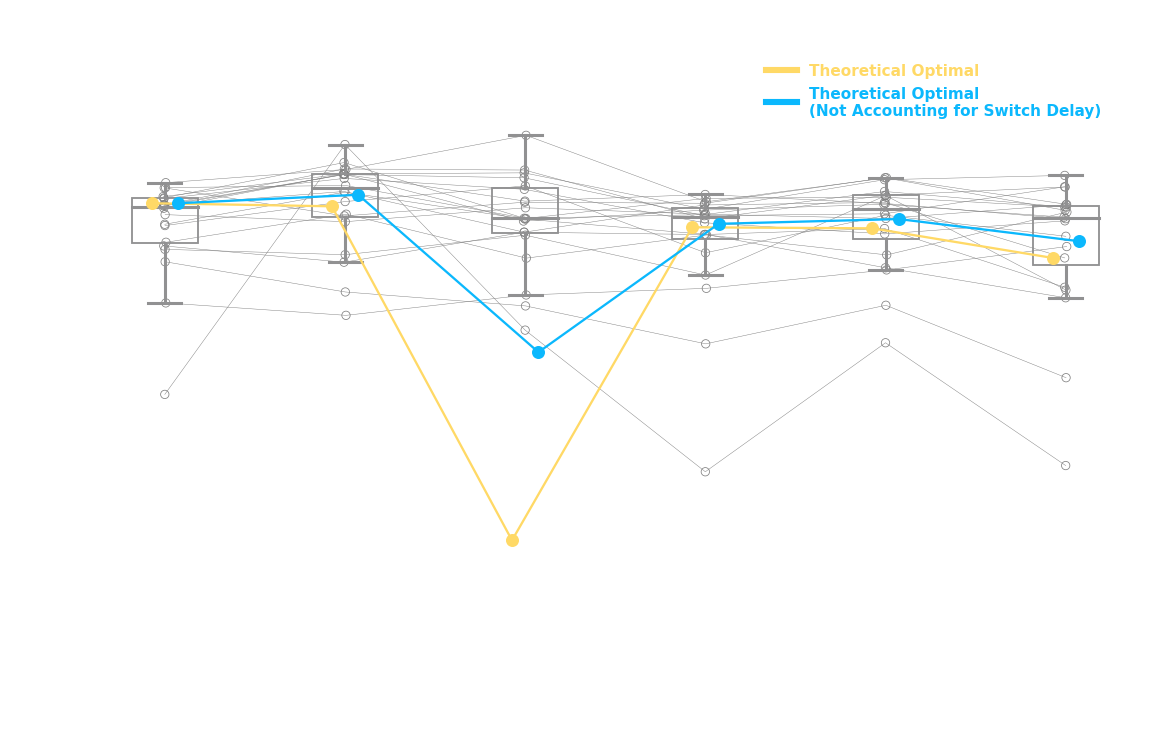

In [82]:
if True:
    xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
    legend_fontsize = 10

    metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    ylocs = np.arange(200, 1601, 200)
    ylabel = 'Time (ms)'
    title = 'Median Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in models.values()]
    pf.multiple_models_boxplot_v2(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=list(models.keys()),
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=25,
        )
    ax.set_ylim(200,1600)
    fig.remove_figure_borders()


## SD Movement Onset

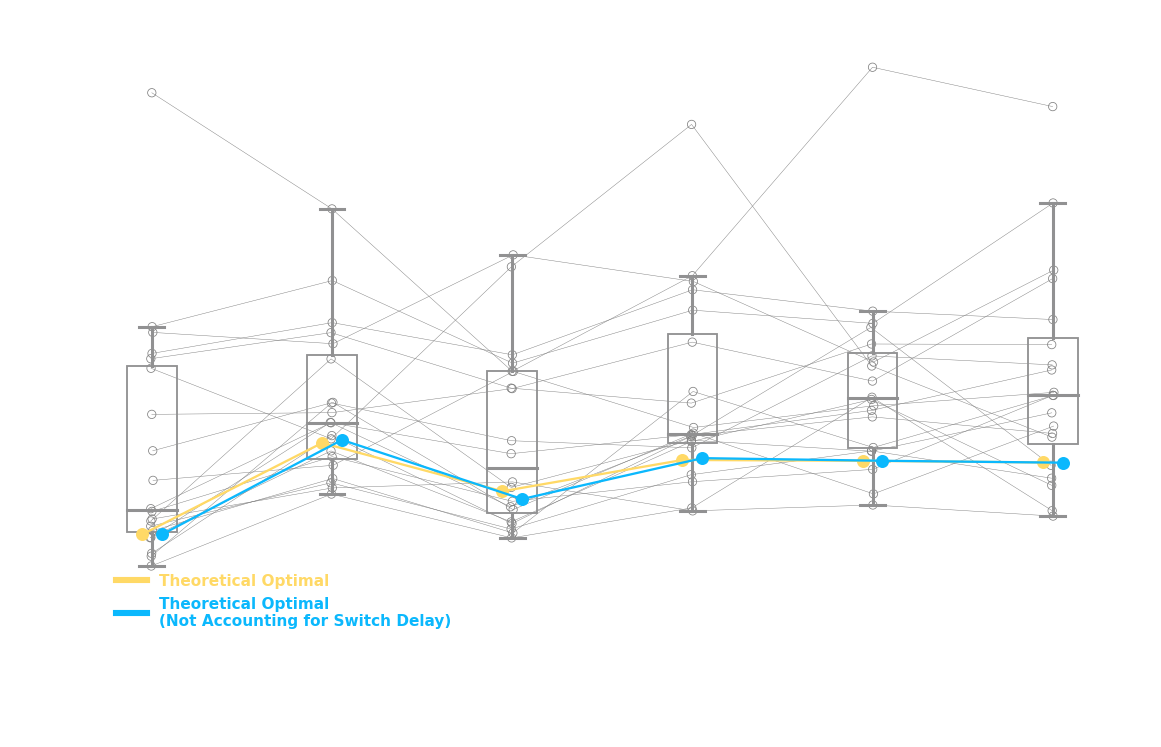

In [83]:
if True:
    xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
    legend_fontsize = 10

    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    ylocs = np.arange(0, 201, 50)
    ylabel = 'Time (ms)'
    title = 'SD Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal') for model in models.values()]

    bw = 0.3*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width

    pf.multiple_models_boxplot_v2(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            labels=list(models.keys()),
            show_boxplot=True,
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=20
        )